In [ ]:
!cp '/content/drive/MyDrive/Colab Notebooks/DSLFinalProject/data.zip' /content

In [ ]:
!unzip data.zip

In [ ]:
import pandas as pd
import numpy as np
import librosa
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Loading Development Dataset

In [ ]:
df_dev = pd.read_csv('development.csv', index_col=0)

In [ ]:
df_dev.head()

,path,speakerId,action,object,Self-reported fluency level,First Language spoken,Current language used for work/school,gender,ageRange
Id,,,,,,,,,
0,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/0a312...,2BqVo8kVB2Skwgyb,change language,none,advanced,English (United States),English (United States),female,22-40
1,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/0ee42...,2BqVo8kVB2Skwgyb,activate,music,advanced,English (United States),English (United States),female,22-40
2,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/1d9f3...,2BqVo8kVB2Skwgyb,deactivate,lights,advanced,English (United States),English (United States),female,22-40
3,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/269fc...,2BqVo8kVB2Skwgyb,increase,volume,advanced,English (United States),English (United States),female,22-40
4,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/5bbda...,2BqVo8kVB2Skwgyb,increase,volume,advanced,English (United States),English (United States),female,22-40


# Preprocess

## Delete some columns

In [ ]:
df_dev['class'] = df_dev['action'] + ' ' + df_dev['object']

In [ ]:
df_dev.drop(['action', 'object'], axis=1, inplace=True)

In [ ]:
df_dev['speakerId'].nunique()

87

<p1> Because of high cardinality, it is dropped

In [ ]:
df_dev.drop('speakerId', axis=1, inplace=True)

In [ ]:
df_dev['Self-reported fluency level '].value_counts() / df_dev['Self-reported fluency level '].value_counts().sum()

native          0.958393
advanced        0.035113
basic           0.005683
intermediate    0.000812
Name: Self-reported fluency level , dtype: float64

In [ ]:
df_dev['First Language spoken'].value_counts() / df_dev['First Language spoken'].value_counts().sum()

English (United States)    0.978486
French (Canada)            0.015019
Spanish (Venezuela)        0.003552
Telugu                     0.002131
English (Canada)           0.000812
Name: First Language spoken, dtype: float64

In [ ]:
df_dev['Current language used for work/school'].value_counts() / df_dev['Current language used for work/school'].value_counts().sum()

English (United States)    0.974021
English (Canada)           0.015831
English (Australia)        0.006596
Spanish (Venezuela)        0.003552
Name: Current language used for work/school, dtype: float64

<p1> Three above columns have dominant values, so they are dropped </p1>

In [ ]:
df_dev.drop(['Self-reported fluency level ', 'First Language spoken',
               'Current language used for work/school'], axis=1, inplace=True)

<Axes: xlabel='gender', ylabel='count'>

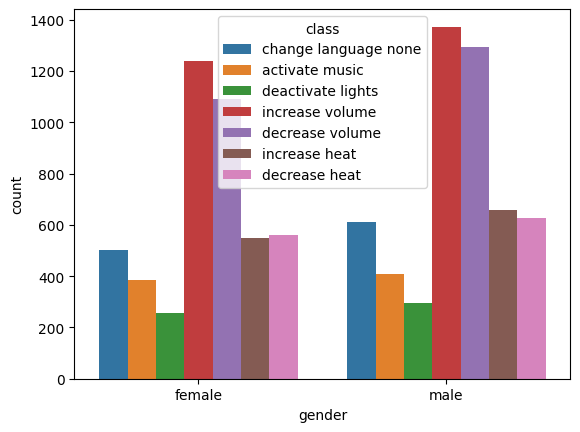

In [ ]:
sns.countplot(data=df_dev, x="gender", hue="class")

<Axes: xlabel='ageRange', ylabel='count'>

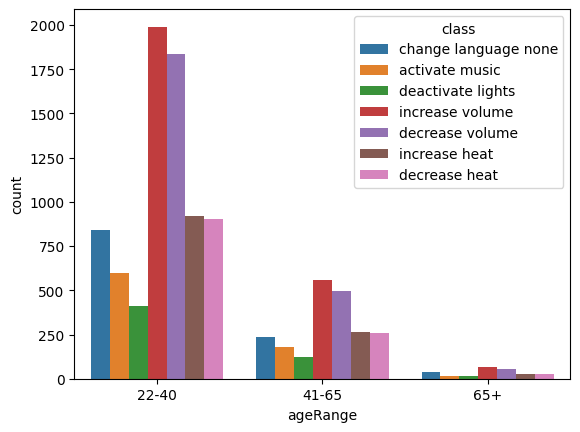

In [ ]:
sns.countplot(data=df_dev, x="ageRange", hue="class")

<p1> In gender and ageRange columns, values follow the same pattern in different classes, so knowing their values cannot help the model predict the class </p1>

In [ ]:
df_dev.drop(['gender', 'ageRange'], axis=1, inplace=True)

## Some statistics

In [ ]:
def load_audio_file(path):

    y, sr = librosa.load(path)
    y, _ = librosa.effects.trim(y=y, top_db=10, hop_length=10)
    duration = librosa.get_duration(y=y, sr=sr)
        
    return y, sr, duration

In [ ]:
df_dev[['info', 'sr', 'duration']] = df_dev.apply(lambda r: load_audio_file(r['path']), axis=1, result_type='expand')

In [ ]:
df_dev.drop('path', axis=1, inplace=True)

In [ ]:
df_dev['sr'].unique()

array([22050])

In [ ]:
df_dev.drop('sr', axis=1, inplace=True)

In [ ]:
def map_duration(duration):
    
  if 0 <= duration < 1:
      return '0-1'
  elif 1 <= duration < 2:
      return '1-2'
  elif 2 <= duration < 3:
      return '2-3'
  elif 3 <= duration < 4:
      return '3-4'
  elif 4 <= duration < 5:
      return '4-5'
  else:
      return '>=5'

In [ ]:
df_dev['duration_interval'] = df_dev.apply(lambda r: map_duration(r['duration']), axis=1)

In [ ]:
df_dev['duration_interval'].value_counts()

0-1    7181
1-2    2439
2-3     207
3-4      25
>=5       2
Name: duration_interval, dtype: int64

<p1> Classes are unbalanced </p1>

In [ ]:
df_dev.drop('duration_interval', axis=1, inplace=True)

In [ ]:
print('Mean of duration -> ', df_dev['duration'].mean())
print('Standard Deviation of duration -> ', df_dev['duration'].std())
print('Max of duration -> ', df_dev['duration'].max())
print('Min of duration -> ', df_dev['duration'].min())

Mean of duration ->  0.8702567094086129
Standard Deviation of duration ->  0.41265092476967624
Max of duration ->  6.834920634920635
Min of duration ->  0.10158730158730159


## Remove Outliers

In [ ]:
print("Old Shape of data frame: ", df_dev.shape)
upper = np.where(df_dev['duration'] > 4) 
df_dev.drop(upper[0], inplace = True)
print("New Shape of data frame: ", df_dev.shape)

Old Shape of data frame:  (9854, 3)
New Shape of data frame:  (9852, 3)


In [ ]:
df_dev.drop('duration', axis=1, inplace=True)

## Add Padding

In [ ]:
def add_padding(info, upper_bound, isTrainData):
    
  if isTrainData:

    pad = np.zeros(upper_bound - len(info), dtype=np.float32)
    info = np.concatenate([info, pad], 0)
      
  else:
    
    if len(info) > upper_bound: # crop the audio
      info = info[:upper_bound]
    else: # pad the audio
      pad = np.zeros(upper_bound - len(info), dtype=np.float32)
      info = np.concatenate([info, pad],0)
    
  return info

In [ ]:
info_length = [ len(info) for info in df_dev['info'] ]
max_length = max(info_length)

In [ ]:
df_dev['info'] = df_dev.apply(lambda r: add_padding(r['info'], max_length, True), axis=1)

## Compute MFCC

In [ ]:
df_dev['mfcc'] = df_dev.apply(lambda r: librosa.feature.mfcc(y=r['info'], sr=22050), axis=1)

In [ ]:
df_dev.drop('info', axis=1, inplace=True)

In [ ]:
df_dev['mfcc'] = df_dev.apply(lambda r: r['mfcc'].flatten(), axis=1)

In [ ]:
col_names = [f'mfcc{i}' for i in range(len(df_dev.iloc[0]['mfcc']))]
df_new_features = pd.DataFrame(df_dev['mfcc'].tolist(), index=df_dev.index, columns=col_names)
df_dev = pd.concat((df_dev, df_new_features), axis=1)

In [ ]:
df_dev.drop('mfcc', axis=1, inplace=True)

## Split Data

In [ ]:
y = df_dev['class']
X = df_dev.drop(['class'], axis=1)

In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, stratify=y
    )

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, shuffle=True, stratify=y_train_val
)

In [ ]:
len(X_train), len(X_val), len(X_test)

(6304, 1577, 1971)

## Apply PCA

In [ ]:
standard_scaler = StandardScaler().fit(X_train)
X_train_scaled = standard_scaler.transform(X_train)
X_val_scaled = standard_scaler.transform(X_val)

In [ ]:
# finding the best number of components for PCA

possible_n = (3000, 2000, 1000, 500, 200, 100, 50)
accuracy = []

for n in possible_n:
  pca_scaler = PCA(n_components=n).fit(X_train_scaled)
  X_train_pca = pca_scaler.transform(X_train_scaled)
  svc = SVC().fit(X_train_pca, y_train)

  X_val_pca = pca_scaler.transform(X_val_scaled)
  y_pred = svc.predict(X_val_pca)
  accuracy.append(accuracy_score(y_val, y_pred))

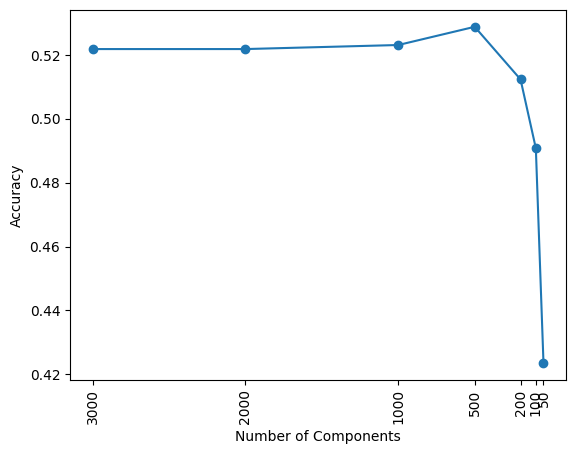

In [ ]:
ax = plt.subplot()
ax.scatter(x=possible_n, y=accuracy)
ax.plot(possible_n, accuracy)
ax.set_xticks(possible_n)
ax.invert_xaxis()
ax.set_xlabel('Number of Components')
plt.xticks(rotation = 90) 
ax.set_ylabel('Accuracy')
plt.savefig('pca.pdf')

# Model Building: Grid Search for SVM's Hyperparameters

In [ ]:
standard_scaler = StandardScaler().fit(X_train_val)
X_train_val_scaled = standard_scaler.transform(X_train_val)

In [ ]:
pca_scaler = PCA(n_components=500).fit(X_train_val_scaled)
X_train_val_pca = pca_scaler.transform(X_train_val_scaled)

In [ ]:
parameters = {
    'kernel':('poly', 'rbf'),
     'C':[1, 4, 10],
     'degree':[1, 2, 3]
     }

svc = SVC()
grid = GridSearchCV(estimator=svc, param_grid=parameters, scoring='accuracy', n_jobs=-1)
grid = grid.fit(X_train_val_pca, y_train_val)

In [ ]:
grid.best_params_

{'C': 10, 'degree': 1, 'kernel': 'rbf'}

In [ ]:
parameters = {
    'kernel': ['rbf',],
     'C':[10, 20, 40, 80],
     'degree': [1,]
     }

svc = SVC()
grid = GridSearchCV(estimator=svc, param_grid=parameters, scoring='accuracy', n_jobs=-1)
grid = grid.fit(X_train_val_pca, y_train_val)

In [ ]:
grid.best_params_

{'C': 40, 'degree': 1, 'kernel': 'rbf'}

In [ ]:
parameters = {
    'kernel': ['rbf',],
     'C':[40, 50, 60, 70],
     'degree': [1,]
     }

svc = SVC()
grid = GridSearchCV(estimator=svc, param_grid=parameters, scoring='accuracy', n_jobs=-1)
grid = grid.fit(X_train_val_pca, y_train_val)

In [ ]:
grid.best_params_

{'C': 40, 'degree': 1, 'kernel': 'rbf'}

# Final Test

In [ ]:
svc = SVC(kernel='rbf', C=40, gamma='scale', class_weight='balanced').fit(X_train_val_pca, y_train_val)

In [ ]:
X_test_scaled = standard_scaler.transform(X_test)
X_test_pca = pca_scaler.transform(X_test_scaled)

In [ ]:
y_pred = svc.predict(X_test_pca)
accuracy_score(y_test, y_pred)

0.7042110603754439